In [27]:
# Step 1: load & split
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load your filtered CICDDoS2019 CSV
file_path = r"C:\Sohan\NTUST\Research_Files\Datasets\CICDDOS2019\filtered_combined_dataset.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

# 2. Binary label: 0=Benign, 1=Attack
df["is_attack"] = (df["Label"].str.upper() != "BENIGN").astype(int)

# 3. Stratified split: 60% train, 20% val, 20% test
df_train, df_tmp = train_test_split(
    df, test_size=0.4, random_state=42, stratify=df["is_attack"]
)
df_val, df_test = train_test_split(
    df_tmp, test_size=0.5, random_state=42, stratify=df_tmp["is_attack"]
)

# 4. (Optional) Save splits for reuse
df_train.to_csv("train_split.csv", index=False)
df_val.  to_csv("val_split.csv",   index=False)
df_test. to_csv("test_split.csv",  index=False)

print("Sizes → train:", len(df_train),
      "val:", len(df_val),
      "test:", len(df_test))


C:\Users\User\AppData\Local\Temp\ipykernel_18628\823886814.py:7: DtypeWarning: Columns (78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Sizes → train: 233445 val: 77815 test: 77815


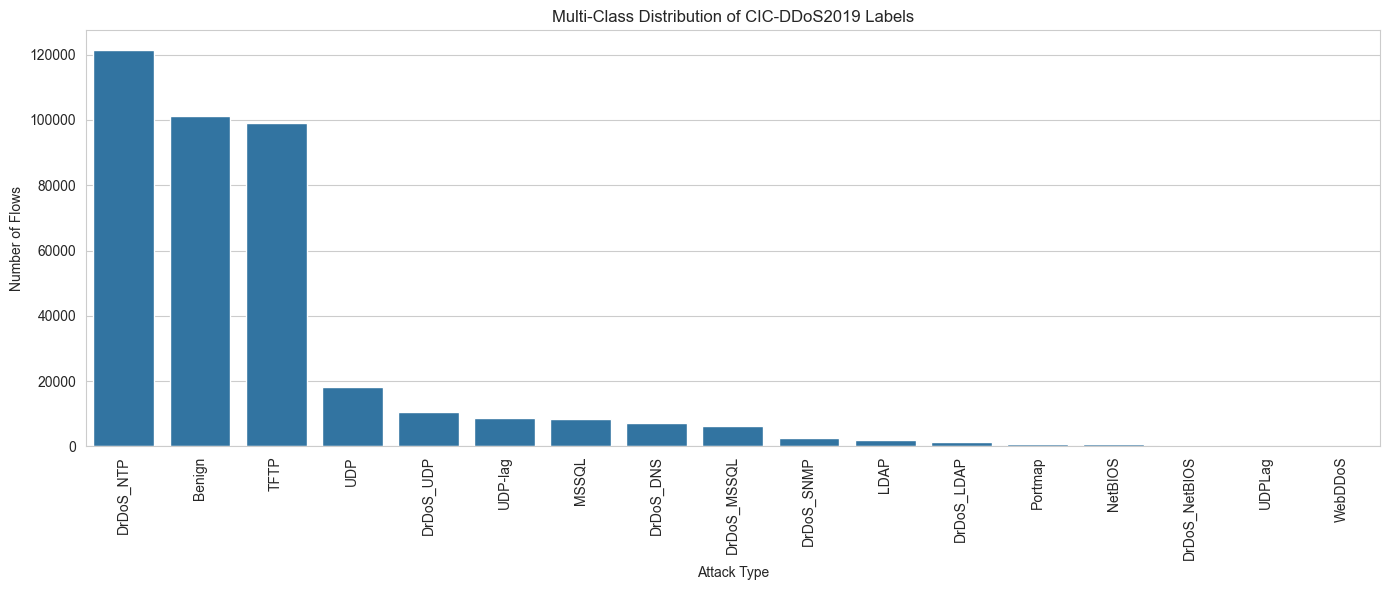

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load & clean
DATA_PATH = r"C:\Sohan\NTUST\Research_Files\Datasets\CICDDOS2019\filtered_combined_dataset.csv"
df = pd.read_csv(DATA_PATH, low_memory=False)
df.columns = df.columns.str.strip()
df['Label'] = df['Label'].str.strip()

# 2) Count each class
label_counts = df['Label'].value_counts()

# 3) Plot
plt.figure(figsize=(14,6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Attack Type")
plt.ylabel("Number of Flows")
plt.title("Multi-Class Distribution of CIC-DDoS2019 Labels")
plt.tight_layout()
plt.show()


In [29]:
# Step 2: Feature cleaning & Mutual‐Information selection (top 50)
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# 1. Reload your train/val/test splits
df_train = pd.read_csv("train_split.csv")
df_val   = pd.read_csv("val_split.csv")
df_test  = pd.read_csv("test_split.csv")

# 2. (Re‐)strip whitespace from all column names
df_train.columns = df_train.columns.str.strip()
df_val.columns   = df_val.columns.str.strip()
df_test.columns  = df_test.columns.str.strip()

# 3. Print out the columns so you can verify the exact names
print("Train columns:", df_train.columns.tolist())
print("Val   columns:", df_val.columns.tolist())
print("Test  columns:", df_test.columns.tolist())

# 4. Define the columns you *intend* to drop
drop_cols = ["Flow ID", "Timestamp", "Label", "Attack Type", "is_attack"]

# 5. Drop only those that actually exist (errors='ignore' also works)
X_train = (
    df_train
      .drop(columns=[c for c in drop_cols if c in df_train.columns], axis=1)
      .select_dtypes(include=np.number)
)
X_val = (
    df_val
      .drop(columns=[c for c in drop_cols if c in df_val.columns], axis=1)
      .select_dtypes(include=np.number)
)
X_test = (
    df_test
      .drop(columns=[c for c in drop_cols if c in df_test.columns], axis=1)
      .select_dtypes(include=np.number)
)

y_train = df_train["is_attack"].values
y_val   = df_val["is_attack"].values
y_test  = df_test["is_attack"].values

# 6. Compute Mutual Information on train, pick the top 50 features
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
top50_idx = np.argsort(mi_scores)[-50:]

X_train = X_train.iloc[:, top50_idx]
X_val   = X_val.iloc[:,   top50_idx]
X_test  = X_test.iloc[:,  top50_idx]

print("→ Kept top-50 features:", X_train.columns.tolist())


Train columns: ['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Coun

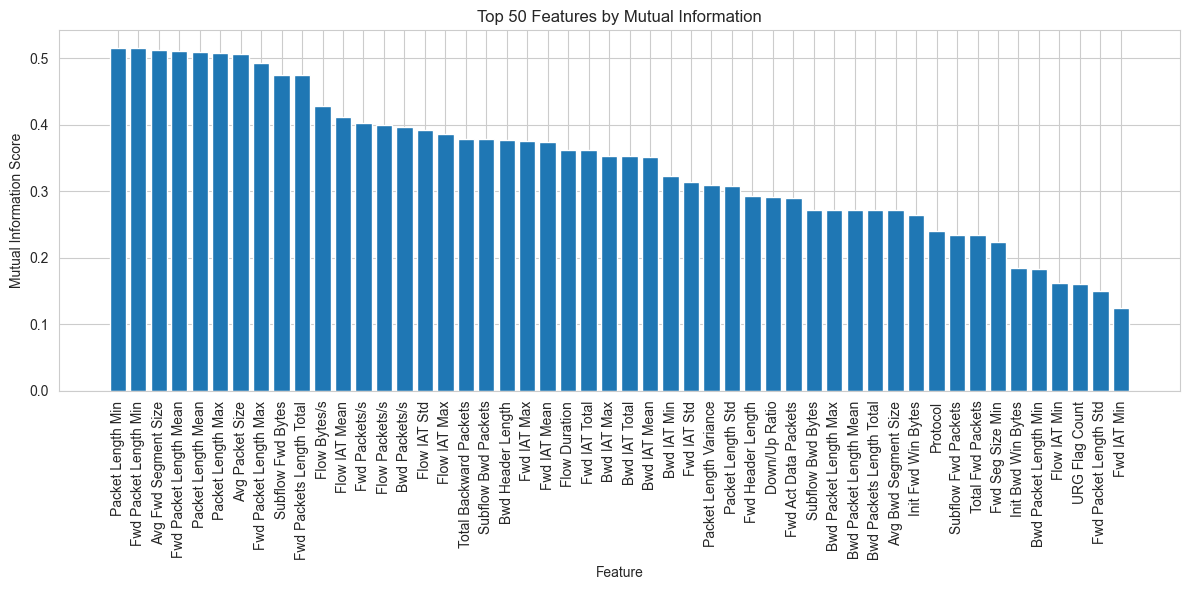

In [30]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# 1. Load your train split (update path if needed)
df_train = pd.read_csv("train_split.csv")  
df_train.columns = df_train.columns.str.strip()

# 2. Prepare X, y
drop_cols = ["Flow ID", "Timestamp", "Label", "Attack Type", "is_attack"]
X = df_train.drop(columns=[c for c in drop_cols if c in df_train.columns]) \
            .select_dtypes(include=np.number)
y = df_train["is_attack"].values

# 3. Compute MI and pick top50
mi_scores = mutual_info_classif(X, y, random_state=42)
idxs      = np.argsort(mi_scores)[-50:]
top_feats = X.columns[idxs]
top_scores= mi_scores[idxs]

# 4. Sort descending and plot
order     = np.argsort(top_scores)[::-1]
top_feats = top_feats[order]
top_scores= top_scores[order]

plt.figure(figsize=(12, 6))
plt.bar(range(50), top_scores)
plt.xticks(range(50), top_feats, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Mutual Information Score")
plt.title("Top 50 Features by Mutual Information")
plt.tight_layout()
plt.show()



In [31]:
X_train, X_val, X_test  # from Step 2 (each is a NumPy‐backed DataFrame of top-50 numeric features)
y_train, y_val, y_test  # binary arrays (0=Benign, 1=Attack)

(array([0, 1, 0, ..., 1, 1, 1]),
 array([1, 0, 1, ..., 1, 1, 0]),
 array([0, 1, 1, ..., 1, 0, 0]))

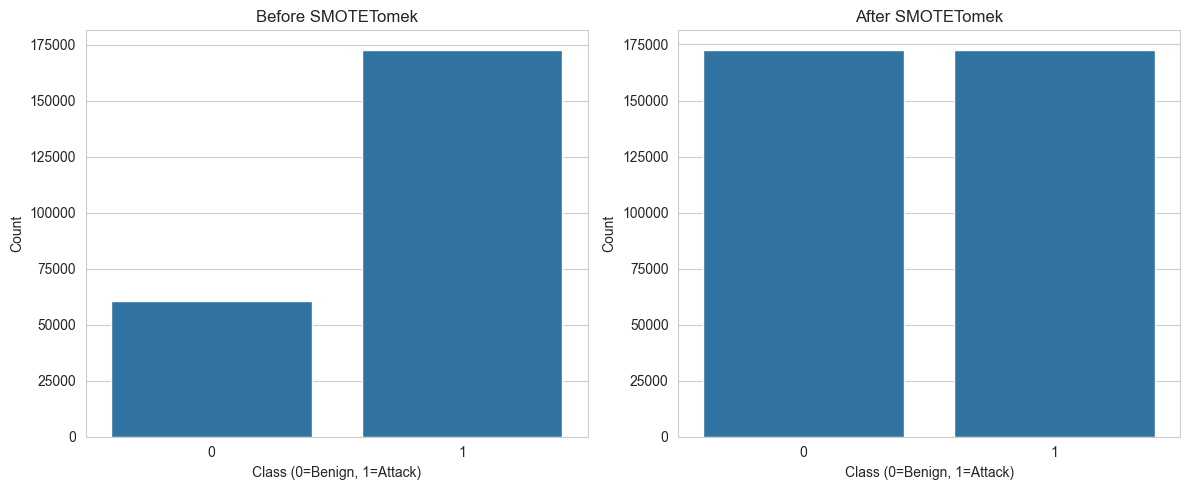

In [32]:
# Step 3: scale + SMOTETomek
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek

# — 1. Standardize features —
scaler = StandardScaler().fit(X_train)              # fit on train
X_train_scaled = scaler.transform(X_train)          # apply to train
X_val_scaled   = scaler.transform(X_val)            # apply to val
X_test_scaled  = scaler.transform(X_test)           # apply to test

# (optional) save for real‐time inference later
joblib.dump(scaler, "standard_scaler.pkl")

# — 2. Balance the training set —
smt = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = smt.fit_resample(X_train_scaled, y_train)

# — 3. Quick before/after plot —
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=y_train, ax=axes[0]).set_title("Before SMOTETomek")
sns.countplot(x=y_train_bal, ax=axes[1]).set_title("After SMOTETomek")
for ax in axes:
    ax.set_xlabel("Class (0=Benign, 1=Attack)")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()



In [33]:
import pandas as pd

df_train = pd.read_csv("train_split.csv")
df_train.columns = df_train.columns.str.strip()   # strip any stray whitespace

# Show them
for i, c in enumerate(df_train.columns):
    print(f"{i:2d}: {repr(c)}")


 0: 'Protocol'
 1: 'Flow Duration'
 2: 'Total Fwd Packets'
 3: 'Total Backward Packets'
 4: 'Fwd Packets Length Total'
 5: 'Bwd Packets Length Total'
 6: 'Fwd Packet Length Max'
 7: 'Fwd Packet Length Min'
 8: 'Fwd Packet Length Mean'
 9: 'Fwd Packet Length Std'
10: 'Bwd Packet Length Max'
11: 'Bwd Packet Length Min'
12: 'Bwd Packet Length Mean'
13: 'Bwd Packet Length Std'
14: 'Flow Bytes/s'
15: 'Flow Packets/s'
16: 'Flow IAT Mean'
17: 'Flow IAT Std'
18: 'Flow IAT Max'
19: 'Flow IAT Min'
20: 'Fwd IAT Total'
21: 'Fwd IAT Mean'
22: 'Fwd IAT Std'
23: 'Fwd IAT Max'
24: 'Fwd IAT Min'
25: 'Bwd IAT Total'
26: 'Bwd IAT Mean'
27: 'Bwd IAT Std'
28: 'Bwd IAT Max'
29: 'Bwd IAT Min'
30: 'Fwd PSH Flags'
31: 'Bwd PSH Flags'
32: 'Fwd URG Flags'
33: 'Bwd URG Flags'
34: 'Fwd Header Length'
35: 'Bwd Header Length'
36: 'Fwd Packets/s'
37: 'Bwd Packets/s'
38: 'Packet Length Min'
39: 'Packet Length Max'
40: 'Packet Length Mean'
41: 'Packet Length Std'
42: 'Packet Length Variance'
43: 'FIN Flag Count'
44: 'S

In [34]:
# Step 5: prepare PyTorch data
import torch
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

# 1. Turn your DataFrames → NumPy arrays
X_tr = X_train.values
X_va = X_val.values
X_te = X_test.values

# 2. Label-encode (though binary, this ensures consistency)
le       = LabelEncoder().fit(y_train)
y_tr_enc = le.transform(y_train)
y_va_enc = le.transform(y_val)
y_te_enc = le.transform(y_test)

# 3. Build TensorDatasets
train_ds = TensorDataset(
    torch.tensor(X_tr, dtype=torch.float32),
    torch.tensor(y_tr_enc, dtype=torch.long)
)
val_ds   = TensorDataset(
    torch.tensor(X_va, dtype=torch.float32),
    torch.tensor(y_va_enc, dtype=torch.long)
)
test_ds  = TensorDataset(
    torch.tensor(X_te, dtype=torch.float32),
    torch.tensor(y_te_enc, dtype=torch.long)
)

# 4. Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

print(f"✅ Train batches: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")


✅ Train batches: 1824, Val: 304, Test: 304


In [35]:
print("Train samples:", len(train_loader.dataset))
print("Val   samples:", len(val_loader.dataset))
print("Test  samples:", len(test_loader.dataset))


Train samples: 233445
Val   samples: 77815
Test  samples: 77815


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from sklearn.metrics import accuracy_score

# ──────────────────────────────────────────────────────────────────────────────
# Change your checkpoint filename here:
MODEL_CHECKPOINT = "nas_dnn_best_v2.pt"
# ──────────────────────────────────────────────────────────────────────────────

# 1. Define your NAS search-space model builder
def define_model(trial, input_dim, output_dim):
    layers   = []
    n_layers = trial.suggest_int("n_layers", 2, 5)
    act_fn   = nn.ReLU() if trial.suggest_categorical("activation", ["relu","tanh"])=="relu" else nn.Tanh()
    dim       = input_dim

    for i in range(n_layers):
        # hidden units
        h = trial.suggest_categorical(f"n_units_l{i}", [128, 256, 384, 512])
        layers += [nn.Linear(dim, h), act_fn]

        # optional batch‐norm
        if trial.suggest_categorical(f"use_bn_l{i}", [0,1]):
            layers.append(nn.BatchNorm1d(h))

        # optional dropout
        dr = trial.suggest_float(f"dropout_l{i}", 0.0, 0.5, step=0.1)
        if dr > 0:
            layers.append(nn.Dropout(dr))

        dim = h

    # output layer (no softmax for CrossEntropyLoss)
    layers.append(nn.Linear(dim, output_dim))
    return nn.Sequential(*layers)


# 2. Objective function with early‐stopping + checkpointing + pruning
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # build model & optimizer
    model = define_model(trial, X_train.shape[1], len(le.classes_)).to(device)
    lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    wd    = trial.suggest_float("weight_decay", 0.0, 1e-3)
    opt   = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    crit  = nn.CrossEntropyLoss()

    # early-stop settings
    patience     = 5
    wait         = 0
    best_val_acc = 0.0

    # history recorder
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss":   [], "val_acc":   []
    }

    for epoch in range(1, 31):  # up to 30 epochs
        # ——— Train ———
        model.train()
        running_loss, corr, total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out   = model(xb)
            loss  = crit(out, yb)
            loss.backward()
            opt.step()

            running_loss += loss.item() * yb.size(0)
            preds        = out.argmax(dim=1)
            corr        += (preds == yb).sum().item()
            total       += yb.size(0)

        train_loss = running_loss / total
        train_acc  = corr / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # ——— Validate ———
        model.eval()
        v_loss, v_corr, v_total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out   = model(xb)
                loss  = crit(out, yb)

                v_loss  += loss.item() * yb.size(0)
                preds   = out.argmax(dim=1)
                v_corr += (preds == yb).sum().item()
                v_total += yb.size(0)

        val_loss = v_loss / v_total
        val_acc  = v_corr / v_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # ——— Early‐stop & checkpoint ———
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            wait = 0
            # save the best model for this trial
            torch.save(model.state_dict(), MODEL_CHECKPOINT)
            # attach history to trial for later inspection
            trial.set_user_attr("history", history.copy())
        else:
            wait += 1
            if wait >= patience:
                break

        # ——— Report & prune ———
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_val_acc


# 3. Run the Optuna study
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
)
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("▶️ Best val accuracy:", study.best_value)
print("🧰 Saved to:", MODEL_CHECKPOINT)
print("⚙️ Best params:", study.best_params)


[I 2025-06-23 11:55:08,045] A new study created in memory with name: no-name-b94cb269-654a-43a9-ab12-f5fa31491557
  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_18628\2124793154.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)
Best trial: 0. Best value: 0.964441:   2%|▏         | 1/50 [00:47<38:47, 47.51s/it]C:\Users\User\AppData\Local\Temp\ipykernel_18628\2124793154.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr    = trial.suggest_loguniform("lr", 1e-4, 1e-2)


[I 2025-06-23 11:55:55,553] Trial 0 finished with value: 0.9644413030906638 and parameters: {'n_layers': 4, 'activation': 'tanh', 'n_units_l0': 256, 'use_bn_l0': 0, 'dropout_l0': 0.4, 'n_units_l1': 256, 'use_bn_l1': 0, 'dropout_l1': 0.30000000000000004, 'n_units_l2': 256, 'use_bn_l2': 0, 'dropout_l2': 0.2, 'n_units_l3': 128, 'use_bn_l3': 1, 'dropout_l3': 0.4, 'lr': 0.005531484653210202, 'weight_decay': 0.00042867009845549633}. Best is trial 0 with value: 0.9644413030906638.


Best trial: 1. Best value: 0.98517:   4%|▍         | 2/50 [01:42<41:18, 51.64s/it] 

[I 2025-06-23 11:56:50,083] Trial 1 finished with value: 0.9851699543789758 and parameters: {'n_layers': 5, 'activation': 'tanh', 'n_units_l0': 256, 'use_bn_l0': 0, 'dropout_l0': 0.30000000000000004, 'n_units_l1': 256, 'use_bn_l1': 1, 'dropout_l1': 0.30000000000000004, 'n_units_l2': 256, 'use_bn_l2': 0, 'dropout_l2': 0.1, 'n_units_l3': 128, 'use_bn_l3': 1, 'dropout_l3': 0.5, 'n_units_l4': 384, 'use_bn_l4': 1, 'dropout_l4': 0.4, 'lr': 0.00017873786613019244, 'weight_decay': 0.0007554005351307601}. Best is trial 1 with value: 0.9851699543789758.


Best trial: 1. Best value: 0.98517:   6%|▌         | 3/50 [02:25<37:29, 47.86s/it]

[I 2025-06-23 11:57:33,448] Trial 2 finished with value: 0.950999164685472 and parameters: {'n_layers': 4, 'activation': 'tanh', 'n_units_l0': 384, 'use_bn_l0': 1, 'dropout_l0': 0.4, 'n_units_l1': 256, 'use_bn_l1': 0, 'dropout_l1': 0.5, 'n_units_l2': 384, 'use_bn_l2': 1, 'dropout_l2': 0.30000000000000004, 'n_units_l3': 512, 'use_bn_l3': 1, 'dropout_l3': 0.30000000000000004, 'lr': 0.004463525719367878, 'weight_decay': 0.0005863309109284797}. Best is trial 1 with value: 0.9851699543789758.


Best trial: 1. Best value: 0.98517:   8%|▊         | 4/50 [03:17<37:52, 49.39s/it]

[I 2025-06-23 11:58:25,201] Trial 3 finished with value: 0.9804022360727366 and parameters: {'n_layers': 3, 'activation': 'tanh', 'n_units_l0': 128, 'use_bn_l0': 1, 'dropout_l0': 0.5, 'n_units_l1': 256, 'use_bn_l1': 1, 'dropout_l1': 0.30000000000000004, 'n_units_l2': 384, 'use_bn_l2': 1, 'dropout_l2': 0.5, 'lr': 0.00027875433256465136, 'weight_decay': 0.0005740199172683293}. Best is trial 1 with value: 0.9851699543789758.


Best trial: 1. Best value: 0.98517:  10%|█         | 5/50 [04:12<38:39, 51.55s/it]

[I 2025-06-23 11:59:20,578] Trial 4 finished with value: 0.9302319604189424 and parameters: {'n_layers': 2, 'activation': 'relu', 'n_units_l0': 128, 'use_bn_l0': 0, 'dropout_l0': 0.30000000000000004, 'n_units_l1': 384, 'use_bn_l1': 1, 'dropout_l1': 0.1, 'lr': 0.009701982631863872, 'weight_decay': 0.0006756861733469835}. Best is trial 1 with value: 0.9851699543789758.


Best trial: 1. Best value: 0.98517:  12%|█▏        | 6/50 [05:42<47:18, 64.52s/it]

[I 2025-06-23 12:00:50,270] Trial 5 finished with value: 0.9693760843025123 and parameters: {'n_layers': 4, 'activation': 'relu', 'n_units_l0': 256, 'use_bn_l0': 0, 'dropout_l0': 0.5, 'n_units_l1': 128, 'use_bn_l1': 1, 'dropout_l1': 0.2, 'n_units_l2': 384, 'use_bn_l2': 0, 'dropout_l2': 0.2, 'n_units_l3': 256, 'use_bn_l3': 1, 'dropout_l3': 0.5, 'lr': 0.0030224105969919486, 'weight_decay': 0.0006355320862807778}. Best is trial 1 with value: 0.9851699543789758.


Best trial: 1. Best value: 0.98517:  14%|█▍        | 7/50 [06:32<42:59, 60.00s/it]

[I 2025-06-23 12:01:40,963] Trial 6 finished with value: 0.9842446829017542 and parameters: {'n_layers': 4, 'activation': 'tanh', 'n_units_l0': 256, 'use_bn_l0': 1, 'dropout_l0': 0.0, 'n_units_l1': 128, 'use_bn_l1': 0, 'dropout_l1': 0.0, 'n_units_l2': 128, 'use_bn_l2': 0, 'dropout_l2': 0.5, 'n_units_l3': 512, 'use_bn_l3': 1, 'dropout_l3': 0.1, 'lr': 0.00036380077227008583, 'weight_decay': 0.0004898175265657451}. Best is trial 1 with value: 0.9851699543789758.


Best trial: 1. Best value: 0.98517:  16%|█▌        | 8/50 [07:20<39:18, 56.15s/it]

[I 2025-06-23 12:02:28,879] Trial 7 finished with value: 0.9354880164492707 and parameters: {'n_layers': 5, 'activation': 'tanh', 'n_units_l0': 256, 'use_bn_l0': 1, 'dropout_l0': 0.4, 'n_units_l1': 128, 'use_bn_l1': 1, 'dropout_l1': 0.5, 'n_units_l2': 128, 'use_bn_l2': 0, 'dropout_l2': 0.5, 'n_units_l3': 256, 'use_bn_l3': 1, 'dropout_l3': 0.2, 'n_units_l4': 128, 'use_bn_l4': 0, 'dropout_l4': 0.0, 'lr': 0.0038134862819944604, 'weight_decay': 0.00045043954381820094}. Best is trial 1 with value: 0.9851699543789758.


Best trial: 1. Best value: 0.98517:  18%|█▊        | 9/50 [07:55<33:49, 49.49s/it]

[I 2025-06-23 12:03:03,720] Trial 8 pruned. 


Best trial: 1. Best value: 0.98517:  20%|██        | 10/50 [08:34<30:46, 46.16s/it]

[I 2025-06-23 12:03:42,414] Trial 9 finished with value: 0.9798624943776907 and parameters: {'n_layers': 2, 'activation': 'relu', 'n_units_l0': 128, 'use_bn_l0': 0, 'dropout_l0': 0.0, 'n_units_l1': 384, 'use_bn_l1': 0, 'dropout_l1': 0.2, 'lr': 0.001524722533482831, 'weight_decay': 0.0007926091588506065}. Best is trial 1 with value: 0.9851699543789758.


Best trial: 10. Best value: 0.988987:  22%|██▏       | 11/50 [10:28<43:37, 67.11s/it]

[I 2025-06-23 12:05:37,024] Trial 10 finished with value: 0.9889866992225149 and parameters: {'n_layers': 5, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.2, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.4, 'n_units_l2': 256, 'use_bn_l2': 1, 'dropout_l2': 0.0, 'n_units_l3': 384, 'use_bn_l3': 0, 'dropout_l3': 0.0, 'n_units_l4': 384, 'use_bn_l4': 1, 'dropout_l4': 0.5, 'lr': 0.0001091788012697694, 'weight_decay': 0.00014609537681897224}. Best is trial 10 with value: 0.9889866992225149.


Best trial: 10. Best value: 0.988987:  24%|██▍       | 12/50 [11:15<38:37, 60.98s/it]

[I 2025-06-23 12:06:23,999] Trial 11 pruned. 


Best trial: 10. Best value: 0.988987:  26%|██▌       | 13/50 [12:54<44:38, 72.38s/it]

[I 2025-06-23 12:08:02,617] Trial 12 finished with value: 0.9711238193150421 and parameters: {'n_layers': 5, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.2, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.4, 'n_units_l2': 256, 'use_bn_l2': 1, 'dropout_l2': 0.0, 'n_units_l3': 384, 'use_bn_l3': 0, 'dropout_l3': 0.0, 'n_units_l4': 384, 'use_bn_l4': 1, 'dropout_l4': 0.5, 'lr': 0.00010045847819810589, 'weight_decay': 0.0009673285054812546}. Best is trial 10 with value: 0.9889866992225149.


Best trial: 13. Best value: 0.992572:  28%|██▊       | 14/50 [14:34<48:28, 80.79s/it]

[I 2025-06-23 12:09:42,834] Trial 13 finished with value: 0.9925721261967487 and parameters: {'n_layers': 5, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.1, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.4, 'n_units_l2': 256, 'use_bn_l2': 1, 'dropout_l2': 0.1, 'n_units_l3': 128, 'use_bn_l3': 0, 'dropout_l3': 0.2, 'n_units_l4': 384, 'use_bn_l4': 1, 'dropout_l4': 0.4, 'lr': 0.0003084676984949481, 'weight_decay': 2.5572648540163594e-06}. Best is trial 13 with value: 0.9925721261967487.


Best trial: 13. Best value: 0.992572:  30%|███       | 15/50 [16:03<48:30, 83.15s/it]

[I 2025-06-23 12:11:11,459] Trial 14 finished with value: 0.992250851378269 and parameters: {'n_layers': 3, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.1, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.4, 'n_units_l2': 256, 'use_bn_l2': 1, 'dropout_l2': 0.1, 'lr': 0.0005573082877223552, 'weight_decay': 1.0790233246738652e-06}. Best is trial 13 with value: 0.9925721261967487.


Best trial: 15. Best value: 0.992983:  32%|███▏      | 16/50 [17:54<51:57, 91.68s/it]

[I 2025-06-23 12:13:02,953] Trial 15 finished with value: 0.9929833579644027 and parameters: {'n_layers': 3, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.1, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.4, 'n_units_l2': 512, 'use_bn_l2': 1, 'dropout_l2': 0.1, 'lr': 0.0006240599641075669, 'weight_decay': 1.42094714988307e-07}. Best is trial 15 with value: 0.9929833579644027.


Best trial: 15. Best value: 0.992983:  34%|███▍      | 17/50 [19:37<52:09, 94.84s/it]

[I 2025-06-23 12:14:45,150] Trial 16 pruned. 


Best trial: 15. Best value: 0.992983:  36%|███▌      | 18/50 [20:43<46:03, 86.35s/it]

[I 2025-06-23 12:15:51,717] Trial 17 finished with value: 0.9876501959776393 and parameters: {'n_layers': 3, 'activation': 'relu', 'n_units_l0': 384, 'use_bn_l0': 0, 'dropout_l0': 0.1, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.30000000000000004, 'n_units_l2': 512, 'use_bn_l2': 1, 'dropout_l2': 0.1, 'lr': 0.0007657487952509512, 'weight_decay': 0.0002754979396530905}. Best is trial 15 with value: 0.9929833579644027.


Best trial: 15. Best value: 0.992983:  38%|███▊      | 19/50 [21:16<36:16, 70.22s/it]

[I 2025-06-23 12:16:24,355] Trial 18 pruned. 


Best trial: 19. Best value: 0.993138:  40%|████      | 20/50 [24:33<54:12, 108.41s/it]

[I 2025-06-23 12:19:41,774] Trial 19 finished with value: 0.993137569877273 and parameters: {'n_layers': 3, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.1, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.2, 'n_units_l2': 512, 'use_bn_l2': 1, 'dropout_l2': 0.2, 'lr': 0.00042903675045758213, 'weight_decay': 8.643039543179983e-06}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  42%|████▏     | 21/50 [26:06<50:09, 103.79s/it]

[I 2025-06-23 12:21:14,803] Trial 20 finished with value: 0.9895007389320825 and parameters: {'n_layers': 3, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.1, 'n_units_l1': 384, 'use_bn_l1': 1, 'dropout_l1': 0.1, 'n_units_l2': 512, 'use_bn_l2': 1, 'dropout_l2': 0.30000000000000004, 'lr': 0.0005076869194159641, 'weight_decay': 0.00010998732511711299}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  44%|████▍     | 22/50 [27:45<47:39, 102.13s/it]

[I 2025-06-23 12:22:53,058] Trial 21 pruned. 


Best trial: 19. Best value: 0.993138:  46%|████▌     | 23/50 [28:19<36:48, 81.78s/it] 

[I 2025-06-23 12:23:27,372] Trial 22 pruned. 


Best trial: 19. Best value: 0.993138:  48%|████▊     | 24/50 [28:58<29:55, 69.07s/it]

[I 2025-06-23 12:24:06,793] Trial 23 pruned. 


Best trial: 19. Best value: 0.993138:  50%|█████     | 25/50 [30:46<33:39, 80.76s/it]

[I 2025-06-23 12:25:54,833] Trial 24 pruned. 


Best trial: 19. Best value: 0.993138:  52%|█████▏    | 26/50 [31:24<27:09, 67.90s/it]

[I 2025-06-23 12:26:32,743] Trial 25 pruned. 


Best trial: 19. Best value: 0.993138:  54%|█████▍    | 27/50 [32:48<27:53, 72.77s/it]

[I 2025-06-23 12:27:56,849] Trial 26 pruned. 


Best trial: 19. Best value: 0.993138:  56%|█████▌    | 28/50 [33:31<23:20, 63.67s/it]

[I 2025-06-23 12:28:39,287] Trial 27 pruned. 


Best trial: 19. Best value: 0.993138:  58%|█████▊    | 29/50 [34:46<23:31, 67.21s/it]

[I 2025-06-23 12:29:54,781] Trial 28 finished with value: 0.9866349675512434 and parameters: {'n_layers': 3, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.30000000000000004, 'n_units_l1': 384, 'use_bn_l1': 1, 'dropout_l1': 0.2, 'n_units_l2': 512, 'use_bn_l2': 1, 'dropout_l2': 0.1, 'lr': 0.0004265301472260526, 'weight_decay': 0.00034165238363831406}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  60%|██████    | 30/50 [36:07<23:44, 71.24s/it]

[I 2025-06-23 12:31:15,425] Trial 29 finished with value: 0.9881128317162501 and parameters: {'n_layers': 4, 'activation': 'relu', 'n_units_l0': 384, 'use_bn_l0': 0, 'dropout_l0': 0.2, 'n_units_l1': 256, 'use_bn_l1': 0, 'dropout_l1': 0.30000000000000004, 'n_units_l2': 512, 'use_bn_l2': 1, 'dropout_l2': 0.2, 'n_units_l3': 128, 'use_bn_l3': 0, 'dropout_l3': 0.1, 'lr': 0.00060405484962019, 'weight_decay': 8.972556353598597e-05}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  62%|██████▏   | 31/50 [37:07<21:31, 67.99s/it]

[I 2025-06-23 12:32:15,815] Trial 30 finished with value: 0.9862622887618069 and parameters: {'n_layers': 3, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.1, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.1, 'n_units_l2': 256, 'use_bn_l2': 1, 'dropout_l2': 0.0, 'lr': 0.0011893804059705847, 'weight_decay': 0.00018650688135243528}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  64%|██████▍   | 32/50 [38:18<20:37, 68.78s/it]

[I 2025-06-23 12:33:26,430] Trial 31 finished with value: 0.9908243911842189 and parameters: {'n_layers': 3, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.1, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.4, 'n_units_l2': 256, 'use_bn_l2': 1, 'dropout_l2': 0.1, 'lr': 0.0006082293156456088, 'weight_decay': 6.121679171983906e-08}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  66%|██████▌   | 33/50 [39:55<21:55, 77.41s/it]

[I 2025-06-23 12:35:03,987] Trial 32 finished with value: 0.9895521429030393 and parameters: {'n_layers': 3, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.0, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.4, 'n_units_l2': 256, 'use_bn_l2': 1, 'dropout_l2': 0.1, 'lr': 0.0002317971474231894, 'weight_decay': 4.25006204932784e-05}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  68%|██████▊   | 34/50 [41:36<22:29, 84.35s/it]

[I 2025-06-23 12:36:44,541] Trial 33 finished with value: 0.9907986891987406 and parameters: {'n_layers': 3, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.1, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.5, 'n_units_l2': 256, 'use_bn_l2': 1, 'dropout_l2': 0.2, 'lr': 0.00038254485473662145, 'weight_decay': 1.8101218213862704e-06}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  70%|███████   | 35/50 [42:39<19:27, 77.87s/it]

[I 2025-06-23 12:37:47,272] Trial 34 finished with value: 0.9871618582535501 and parameters: {'n_layers': 2, 'activation': 'tanh', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.30000000000000004, 'n_units_l1': 256, 'use_bn_l1': 1, 'dropout_l1': 0.30000000000000004, 'lr': 0.0001533025743600759, 'weight_decay': 6.728341024419522e-05}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  72%|███████▏  | 36/50 [43:23<15:50, 67.92s/it]

[I 2025-06-23 12:38:31,990] Trial 35 pruned. 


Best trial: 19. Best value: 0.993138:  74%|███████▍  | 37/50 [43:56<12:23, 57.20s/it]

[I 2025-06-23 12:39:04,169] Trial 36 pruned. 


Best trial: 19. Best value: 0.993138:  76%|███████▌  | 38/50 [46:11<16:07, 80.60s/it]

[I 2025-06-23 12:41:19,376] Trial 37 finished with value: 0.9927391891023581 and parameters: {'n_layers': 4, 'activation': 'relu', 'n_units_l0': 384, 'use_bn_l0': 0, 'dropout_l0': 0.0, 'n_units_l1': 512, 'use_bn_l1': 0, 'dropout_l1': 0.4, 'n_units_l2': 128, 'use_bn_l2': 1, 'dropout_l2': 0.0, 'n_units_l3': 128, 'use_bn_l3': 0, 'dropout_l3': 0.2, 'lr': 0.0002929677010587811, 'weight_decay': 5.622746011604172e-05}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  78%|███████▊  | 39/50 [46:49<12:27, 67.96s/it]

[I 2025-06-23 12:41:57,849] Trial 38 finished with value: 0.9876501959776393 and parameters: {'n_layers': 5, 'activation': 'tanh', 'n_units_l0': 384, 'use_bn_l0': 1, 'dropout_l0': 0.0, 'n_units_l1': 128, 'use_bn_l1': 0, 'dropout_l1': 0.30000000000000004, 'n_units_l2': 128, 'use_bn_l2': 0, 'dropout_l2': 0.0, 'n_units_l3': 128, 'use_bn_l3': 0, 'dropout_l3': 0.2, 'n_units_l4': 512, 'use_bn_l4': 0, 'dropout_l4': 0.2, 'lr': 0.00029637876076185897, 'weight_decay': 0.00035844405702412004}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  80%|████████  | 40/50 [47:49<10:56, 65.62s/it]

[I 2025-06-23 12:42:57,998] Trial 39 finished with value: 0.9877401529268136 and parameters: {'n_layers': 4, 'activation': 'relu', 'n_units_l0': 384, 'use_bn_l0': 0, 'dropout_l0': 0.0, 'n_units_l1': 384, 'use_bn_l1': 0, 'dropout_l1': 0.5, 'n_units_l2': 128, 'use_bn_l2': 1, 'dropout_l2': 0.0, 'n_units_l3': 128, 'use_bn_l3': 0, 'dropout_l3': 0.30000000000000004, 'lr': 0.0003635199711428645, 'weight_decay': 0.00013743313882630417}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  82%|████████▏ | 41/50 [49:15<10:45, 71.69s/it]

[I 2025-06-23 12:44:23,853] Trial 40 finished with value: 0.9891537621281244 and parameters: {'n_layers': 5, 'activation': 'relu', 'n_units_l0': 384, 'use_bn_l0': 1, 'dropout_l0': 0.4, 'n_units_l1': 128, 'use_bn_l1': 0, 'dropout_l1': 0.30000000000000004, 'n_units_l2': 128, 'use_bn_l2': 1, 'dropout_l2': 0.0, 'n_units_l3': 128, 'use_bn_l3': 0, 'dropout_l3': 0.2, 'n_units_l4': 256, 'use_bn_l4': 1, 'dropout_l4': 0.30000000000000004, 'lr': 0.00024421769381696706, 'weight_decay': 5.8248726799366535e-05}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  84%|████████▍ | 42/50 [50:49<10:26, 78.33s/it]

[I 2025-06-23 12:45:57,692] Trial 41 finished with value: 0.9914797918139177 and parameters: {'n_layers': 4, 'activation': 'relu', 'n_units_l0': 384, 'use_bn_l0': 0, 'dropout_l0': 0.0, 'n_units_l1': 512, 'use_bn_l1': 0, 'dropout_l1': 0.4, 'n_units_l2': 384, 'use_bn_l2': 1, 'dropout_l2': 0.1, 'n_units_l3': 128, 'use_bn_l3': 0, 'dropout_l3': 0.1, 'lr': 0.000563445530336173, 'weight_decay': 1.1280170959847837e-06}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  86%|████████▌ | 43/50 [51:17<07:22, 63.19s/it]

[I 2025-06-23 12:46:25,526] Trial 42 pruned. 


Best trial: 19. Best value: 0.993138:  88%|████████▊ | 44/50 [51:48<05:20, 53.47s/it]

[I 2025-06-23 12:46:56,328] Trial 43 pruned. 


Best trial: 19. Best value: 0.993138:  90%|█████████ | 45/50 [52:21<03:57, 47.49s/it]

[I 2025-06-23 12:47:29,880] Trial 44 pruned. 


Best trial: 19. Best value: 0.993138:  92%|█████████▏| 46/50 [52:56<02:54, 43.63s/it]

[I 2025-06-23 12:48:04,499] Trial 45 finished with value: 0.9769710210113731 and parameters: {'n_layers': 3, 'activation': 'tanh', 'n_units_l0': 256, 'use_bn_l0': 0, 'dropout_l0': 0.2, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.4, 'n_units_l2': 128, 'use_bn_l2': 1, 'dropout_l2': 0.0, 'lr': 0.0004356414654450291, 'weight_decay': 0.0005244362915906823}. Best is trial 19 with value: 0.993137569877273.


Best trial: 19. Best value: 0.993138:  94%|█████████▍| 47/50 [53:25<01:57, 39.30s/it]

[I 2025-06-23 12:48:33,683] Trial 46 pruned. 


Best trial: 19. Best value: 0.993138:  96%|█████████▌| 48/50 [54:02<01:17, 38.61s/it]

[I 2025-06-23 12:49:10,702] Trial 47 pruned. 


Best trial: 19. Best value: 0.993138:  98%|█████████▊| 49/50 [54:28<00:34, 34.71s/it]

[I 2025-06-23 12:49:36,309] Trial 48 pruned. 


Best trial: 19. Best value: 0.993138: 100%|██████████| 50/50 [55:00<00:00, 66.01s/it]

[I 2025-06-23 12:50:08,695] Trial 49 pruned. 
▶️ Best val accuracy: 0.993137569877273
🧰 Saved to: nas_dnn_best_v2.pt
⚙️ Best params: {'n_layers': 3, 'activation': 'relu', 'n_units_l0': 512, 'use_bn_l0': 0, 'dropout_l0': 0.1, 'n_units_l1': 512, 'use_bn_l1': 1, 'dropout_l1': 0.2, 'n_units_l2': 512, 'use_bn_l2': 1, 'dropout_l2': 0.2, 'lr': 0.00042903675045758213, 'weight_decay': 8.643039543179983e-06}


In [37]:
def build_model_from_params(params, input_dim, output_dim):
    import torch.nn as nn

    layers = []
    activation = nn.ReLU() if params["activation"]=="relu" else nn.Tanh()
    dim = input_dim

    # Hidden layers
    for i in range(params["n_layers"]):
        h = params[f"n_units_l{i}"]
        layers += [nn.Linear(dim, h), activation]
        if params.get(f"use_bn_l{i}", 0):
            layers.append(nn.BatchNorm1d(h))
        dr = params.get(f"dropout_l{i}", 0.0)
        if dr>0:
            layers.append(nn.Dropout(dr))
        dim = h

    # Output
    layers.append(nn.Linear(dim, output_dim))
    return nn.Sequential(*layers)


In [38]:
# === Final Fit: Rebuild & Train Best Model on Train+Val ===

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import ConcatDataset, DataLoader

# 0) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1) Get best params from Optuna search
best_params = study.best_params
BS = 128

# 2) Combine train and val datasets (full labeled data, except test)
full_train_ds = ConcatDataset([train_ds, val_ds])
train_loader = DataLoader(full_train_ds, batch_size=BS, shuffle=True, num_workers=4, pin_memory=True)

# 3) Rebuild the best architecture exactly
def build_best_model(params, input_dim, output_dim):
    layers = []
    act_fn = nn.ReLU() if params["activation"] == "relu" else nn.Tanh()
    dim = input_dim
    for i in range(params["n_layers"]):
        h = params[f"n_units_l{i}"]
        layers.append(nn.Linear(dim, h))
        layers.append(act_fn)
        if params.get(f"use_bn_l{i}", 0):
            layers.append(nn.BatchNorm1d(h))
        dr = params.get(f"dropout_l{i}", 0.0)
        if dr > 0:
            layers.append(nn.Dropout(dr))
        dim = h
    layers.append(nn.Linear(dim, output_dim))
    return nn.Sequential(*layers)

input_dim = train_ds.tensors[0].shape[1]
output_dim = 2  # binary: benign/attack

model = build_best_model(best_params, input_dim, output_dim).to(device)

# (Optionally: Uncomment below if you want to fine-tune from checkpoint, but usually start from scratch)
# ckpt = torch.load("nas_dnn_best_v2.pt", map_location=device)
# model.load_state_dict(ckpt, strict=False)

# 4) Train for N epochs
optimizer = optim.Adam(
    model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)
criterion = nn.CrossEntropyLoss()

EPOCHS = 30
history = {"train_loss":[], "train_acc":[]}

for epoch in range(1, EPOCHS+1):
    model.train()
    t_loss = t_corr = t_tot = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        preds = out.argmax(dim=1)
        t_loss += loss.item() * yb.size(0)
        t_corr += (preds == yb).sum().item()
        t_tot += yb.size(0)
    history["train_loss"].append(t_loss/t_tot)
    history["train_acc"].append(t_corr/t_tot)
    print(f"Epoch {epoch:02d} | train_loss={history['train_loss'][-1]:.4f}, train_acc={history['train_acc'][-1]:.4f}")

# 5) Save the final model
torch.save(model.state_dict(), "nas_dnn_final.pt")
print("✅ Final model saved as nas_dnn_final.pt (use this for Ryu deployment)")

Using device: cuda
Epoch 01 | train_loss=0.1818, train_acc=0.9408
Epoch 02 | train_loss=0.1103, train_acc=0.9647
Epoch 03 | train_loss=0.0737, train_acc=0.9780
Epoch 04 | train_loss=0.0616, train_acc=0.9827
Epoch 05 | train_loss=0.0552, train_acc=0.9843
Epoch 06 | train_loss=0.0467, train_acc=0.9875
Epoch 07 | train_loss=0.0440, train_acc=0.9884
Epoch 08 | train_loss=0.0398, train_acc=0.9897
Epoch 09 | train_loss=0.0370, train_acc=0.9904
Epoch 10 | train_loss=0.0370, train_acc=0.9905
Epoch 11 | train_loss=0.0359, train_acc=0.9906
Epoch 12 | train_loss=0.0360, train_acc=0.9906
Epoch 13 | train_loss=0.0343, train_acc=0.9913
Epoch 14 | train_loss=0.0344, train_acc=0.9912
Epoch 15 | train_loss=0.0337, train_acc=0.9913
Epoch 16 | train_loss=0.0331, train_acc=0.9915
Epoch 17 | train_loss=0.0334, train_acc=0.9914
Epoch 18 | train_loss=0.0328, train_acc=0.9916
Epoch 19 | train_loss=0.0337, train_acc=0.9910
Epoch 20 | train_loss=0.0334, train_acc=0.9913
Epoch 21 | train_loss=0.0325, train_acc=0

In [46]:
# === Final Fit: Rebuild & Train Best Model on Train+Val ===

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import ConcatDataset, DataLoader

# 0) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1) Get best params from Optuna search
best_params = study.best_params
BS = 128

# 2) Combine train and val datasets (full labeled data, except test)
full_train_ds = ConcatDataset([train_ds, val_ds])
train_loader = DataLoader(full_train_ds, batch_size=BS, shuffle=True, num_workers=4, pin_memory=True)

# 3) Rebuild the best architecture exactly
def build_best_model(params, input_dim, output_dim):
    layers = []
    act_fn = nn.ReLU() if params["activation"] == "relu" else nn.Tanh()
    dim = input_dim
    for i in range(params["n_layers"]):
        h = params[f"n_units_l{i}"]
        layers.append(nn.Linear(dim, h))
        layers.append(act_fn)
        if params.get(f"use_bn_l{i}", 0):
            layers.append(nn.BatchNorm1d(h))
        dr = params.get(f"dropout_l{i}", 0.0)
        if dr > 0:
            layers.append(nn.Dropout(dr))
        dim = h
    layers.append(nn.Linear(dim, output_dim))
    return nn.Sequential(*layers)

input_dim = train_ds.tensors[0].shape[1]
output_dim = 2  # binary: benign/attack

model = build_best_model(best_params, input_dim, output_dim).to(device)

# (Optionally: Uncomment below if you want to fine-tune from checkpoint, but usually start from scratch)
# ckpt = torch.load("nas_dnn_best_v2.pt", map_location=device)
# model.load_state_dict(ckpt, strict=False)

# 4) Train for N epochs
optimizer = optim.Adam(
    model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)
criterion = nn.CrossEntropyLoss()

EPOCHS = 50
history = {"train_loss":[], "train_acc":[]}

for epoch in range(1, EPOCHS+1):
    model.train()
    t_loss = t_corr = t_tot = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        preds = out.argmax(dim=1)
        t_loss += loss.item() * yb.size(0)
        t_corr += (preds == yb).sum().item()
        t_tot += yb.size(0)
    history["train_loss"].append(t_loss/t_tot)
    history["train_acc"].append(t_corr/t_tot)
    print(f"Epoch {epoch:02d} | train_loss={history['train_loss'][-1]:.4f}, train_acc={history['train_acc'][-1]:.4f}")

# 5) Save the final model
torch.save(model.state_dict(), "nas_best_512x3.pt")
print("✅ Final model saved as nas_dnn_final.pt (use this for Ryu deployment)")

Using device: cuda
Epoch 01 | train_loss=0.1866, train_acc=0.9398
Epoch 02 | train_loss=0.1185, train_acc=0.9609
Epoch 03 | train_loss=0.0891, train_acc=0.9706
Epoch 04 | train_loss=0.0649, train_acc=0.9807
Epoch 05 | train_loss=0.0578, train_acc=0.9838
Epoch 06 | train_loss=0.0518, train_acc=0.9860
Epoch 07 | train_loss=0.0464, train_acc=0.9879
Epoch 08 | train_loss=0.0436, train_acc=0.9888
Epoch 09 | train_loss=0.0439, train_acc=0.9886
Epoch 10 | train_loss=0.0403, train_acc=0.9897
Epoch 11 | train_loss=0.0390, train_acc=0.9898
Epoch 12 | train_loss=0.0366, train_acc=0.9907
Epoch 13 | train_loss=0.0358, train_acc=0.9907
Epoch 14 | train_loss=0.0371, train_acc=0.9903
Epoch 15 | train_loss=0.0369, train_acc=0.9901
Epoch 16 | train_loss=0.0357, train_acc=0.9908
Epoch 17 | train_loss=0.0347, train_acc=0.9911
Epoch 18 | train_loss=0.0338, train_acc=0.9914
Epoch 19 | train_loss=0.0336, train_acc=0.9914
Epoch 20 | train_loss=0.0342, train_acc=0.9913
Epoch 21 | train_loss=0.0332, train_acc=0

In [47]:
print(model)
print(model.state_dict().keys())
for k, v in model.state_dict().items():
    print(k, v.shape)

Sequential(
  (0): Linear(in_features=50, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=512, out_features=512, bias=True)
  (8): ReLU()
  (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Dropout(p=0.2, inplace=False)
  (11): Linear(in_features=512, out_features=2, bias=True)
)
odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '5.weight', '5.bias', '5.running_mean', '5.running_var', '5.num_batches_tracked', '7.weight', '7.bias', '9.weight', '9.bias', '9.running_mean', '9.running_var', '9.num_batches_tracked', '11.weight', '11.bias'])
0.weight torch.Size([512, 50])
0.bias torch.Size([512])
3.weight torch.Size([512, 512])
3.bias torch.Size([512])
5.weight torch.Size([512])
5.bias torc

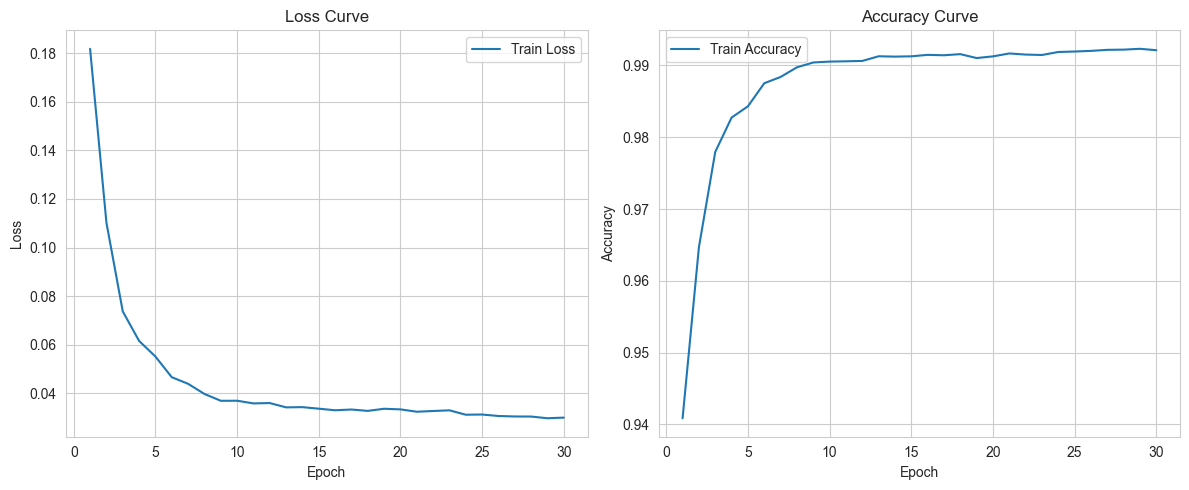

In [40]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"])+1)

plt.figure(figsize=(12,5))

# Loss Curve
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy Curve
plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()



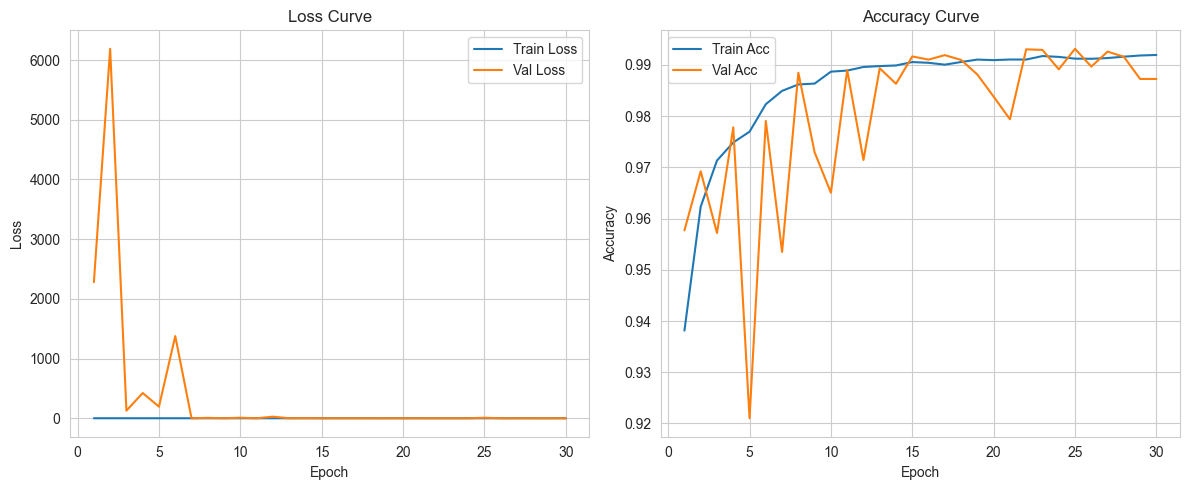

In [48]:
best_history = study.best_trial.user_attrs['history']
epochs = range(1, len(best_history["train_loss"])+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, best_history["train_loss"], label="Train Loss")
plt.plot(epochs, best_history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, best_history["train_acc"], label="Train Acc")
plt.plot(epochs, best_history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

      Benign       0.98      0.99      0.98     20248
      Attack       1.00      0.99      0.99     57567

    accuracy                           0.99     77815
   macro avg       0.99      0.99      0.99     77815
weighted avg       0.99      0.99      0.99     77815



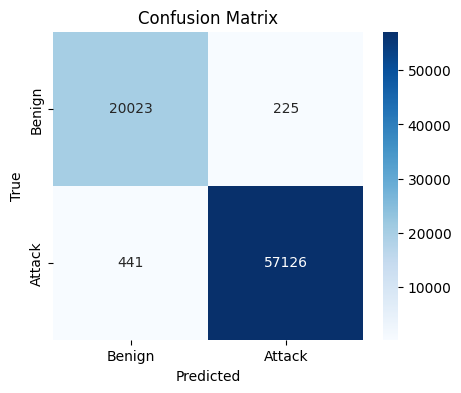

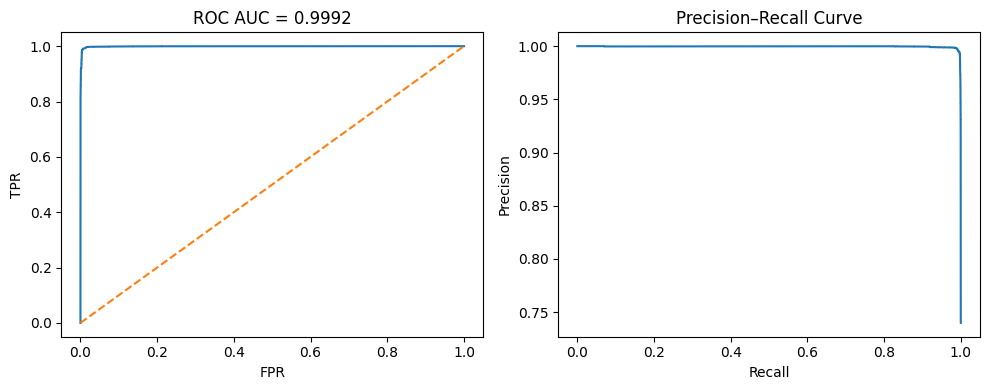

In [ ]:
# Step 9: Final Test Evaluation (precision, recall, F1, ROC, PR, confusion matrix)
import numpy as np
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score, roc_curve,
    precision_recall_curve
)
import matplotlib.pyplot as plt

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        y_pred.append(out.argmax(dim=1).cpu().numpy())
        y_score.append(torch.softmax(out,1)[:,1].cpu().numpy())
        y_true.append(yb.numpy())

y_true  = np.concatenate(y_true)
y_pred  = np.concatenate(y_pred)
y_score = np.concatenate(y_score)

# Classification report
print(classification_report(y_true, y_pred, target_names=["Benign","Attack"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Attack"],
            yticklabels=["Benign","Attack"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# ROC & PR curves
fpr, tpr, _   = roc_curve(y_true, y_score)
prec, rec, _ = precision_recall_curve(y_true, y_score)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.title(f"ROC AUC = {roc_auc_score(y_true,y_score):.4f}")
plt.xlabel("FPR"); plt.ylabel("TPR")

plt.subplot(1,2,2)
plt.plot(rec, prec)
plt.title("Precision–Recall Curve")
plt.xlabel("Recall"); plt.ylabel("Precision")

plt.tight_layout()
plt.show()


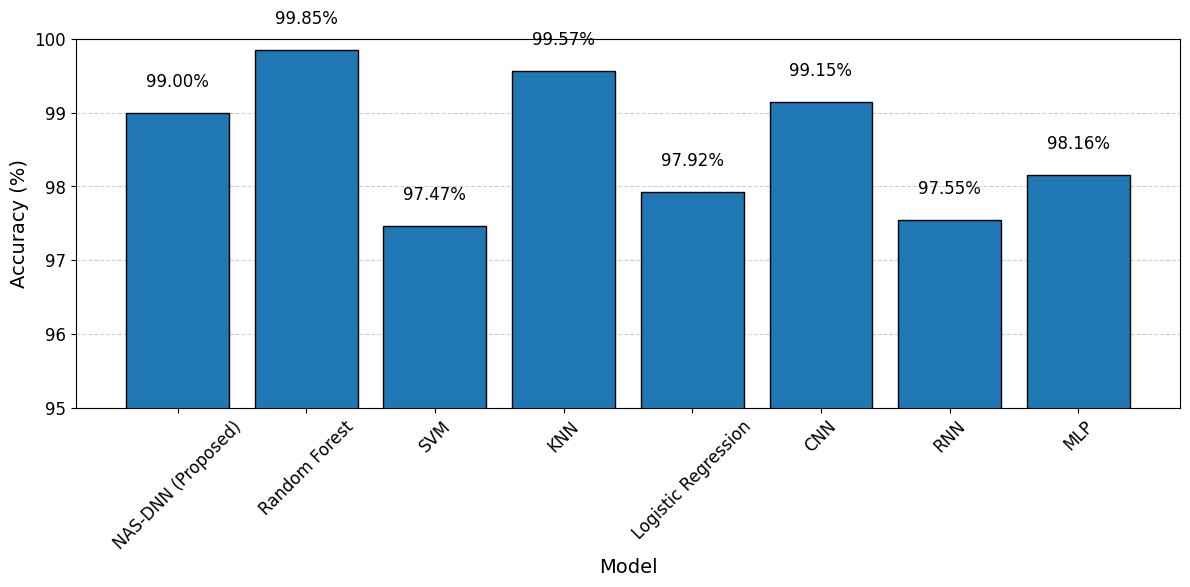

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Define your models and their accuracies (in %)
models = [
    "NAS-DNN (Proposed)",
    "Random Forest",
    "SVM",
    "KNN",
    "Logistic Regression",
    "CNN",
    "RNN",
    "MLP"
]
accuracies = [99.00, 99.85, 97.47, 99.57, 97.92, 99.15, 97.55, 98.16]

# 2) Create the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(models, accuracies, edgecolor="black")

# 3) Formatting
ax.set_ylim(95, 100)  # zoom into the top of the scale
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_xlabel("Model", fontsize=14)


ax.tick_params(axis="x", labelrotation=45, labelsize=12)
ax.tick_params(axis="y", labelsize=12)

# 4) Add gridlines
ax.yaxis.grid(True, linestyle="--", alpha=0.6)
ax.set_axisbelow(True)

# 5) Annotate each bar with its value
for bar, val in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2, 
        height + 0.3, 
        f"{val:.2f}%", 
        ha="center", 
        va="bottom",
        fontsize=12
    )

plt.tight_layout()
plt.show()


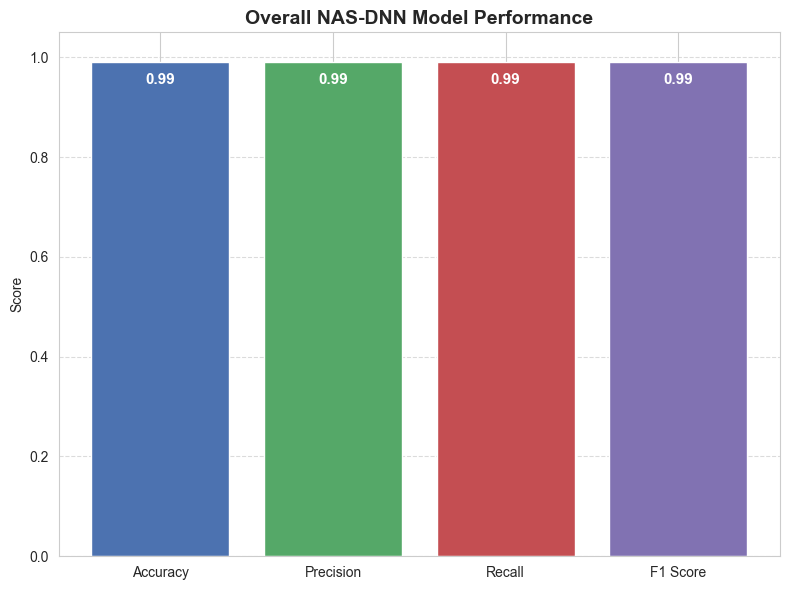

In [ ]:
import matplotlib.pyplot as plt

# Define overall performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [0.99, 0.99, 0.99, 0.99]

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'])
plt.ylim(0.0, 1.05)
plt.ylabel('Score')
plt.title('Overall NAS-DNN Model Performance', fontsize=14, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 0.05, f'{height:.2f}',
             ha='center', va='bottom', color='white', fontweight='bold', fontsize=11)

# Final layout
plt.tight_layout()
plt.savefig('nas_dnn_overall_metrics.png', dpi=300)
plt.show()


In [ ]:
top_feats = X.columns[idxs]         # (as in your screenshot)
# Save as list
top_feats_list = top_feats.tolist()
print(top_feats_list)


['Fwd IAT Min', 'Fwd Packet Length Std', 'URG Flag Count', 'Flow IAT Min', 'Bwd Packet Length Min', 'Init Bwd Win Bytes', 'Fwd Seg Size Min', 'Total Fwd Packets', 'Subflow Fwd Packets', 'Protocol', 'Init Fwd Win Bytes', 'Avg Bwd Segment Size', 'Bwd Packets Length Total', 'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Subflow Bwd Bytes', 'Fwd Act Data Packets', 'Down/Up Ratio', 'Fwd Header Length', 'Packet Length Std', 'Packet Length Variance', 'Fwd IAT Std', 'Bwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Total', 'Bwd IAT Max', 'Fwd IAT Total', 'Flow Duration', 'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd Header Length', 'Subflow Bwd Packets', 'Total Backward Packets', 'Flow IAT Max', 'Flow IAT Std', 'Bwd Packets/s', 'Flow Packets/s', 'Fwd Packets/s', 'Flow IAT Mean', 'Flow Bytes/s', 'Fwd Packets Length Total', 'Subflow Fwd Bytes', 'Fwd Packet Length Max', 'Avg Packet Size', 'Packet Length Max', 'Packet Length Mean', 'Fwd Packet Length Mean', 'Avg Fwd Segment Size', 'Fwd Packet Length Min', 'Packe

In [ ]:
# csv_replay_predict.py
import torch
import numpy as np
import pandas as pd
import joblib

# Load your model definition
class NASBestModel(torch.nn.Sequential):
    def __init__(self, input_dim, output_dim):
        super().__init__(
            torch.nn.Linear(input_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(512, output_dim)
        )

# === Configuration ===
MODEL_PATH = "nas_best_512x3.pt"      # Your final PyTorch weights (state_dict)
SCALER_PATH = "standard_scaler.pkl"
CSV_PATH = r"C:\Sohan\NTUST\Research_Files\VS_FIles\all_sampled_combined.csv"   # The test set you want to replay
FEATURE_NAMES = [
    'Fwd IAT Min', 'Fwd Packet Length Std', 'URG Flag Count', 'Flow IAT Min', 'Bwd Packet Length Min',
    'Init Bwd Win Bytes', 'Fwd Seg Size Min', 'Total Fwd Packets', 'Subflow Fwd Packets', 'Protocol',
    'Init Fwd Win Bytes', 'Avg Bwd Segment Size', 'Bwd Packets Length Total', 'Bwd Packet Length Mean',
    'Bwd Packet Length Max', 'Subflow Bwd Bytes', 'Fwd Act Data Packets', 'Down/Up Ratio', 'Fwd Header Length',
    'Packet Length Std', 'Packet Length Variance', 'Fwd IAT Std', 'Bwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Total',
    'Bwd IAT Max', 'Fwd IAT Total', 'Flow Duration', 'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd Header Length',
    'Subflow Bwd Packets', 'Total Backward Packets', 'Flow IAT Max', 'Flow IAT Std', 'Bwd Packets/s',
    'Flow Packets/s', 'Fwd Packets/s', 'Flow IAT Mean', 'Flow Bytes/s', 'Fwd Packets Length Total',
    'Subflow Fwd Bytes', 'Fwd Packet Length Max', 'Avg Packet Size', 'Packet Length Max', 'Packet Length Mean',
    'Fwd Packet Length Mean', 'Avg Fwd Segment Size', 'Fwd Packet Length Min', 'Packet Length Min'
]               # <<--- Your 50-feature column order (list of strings)
LABEL_COL = "Label"                   # Change if needed

# === Load everything ===
scaler = joblib.load(SCALER_PATH)
df = pd.read_csv(CSV_PATH)
X = df[FEATURE_ORDER].values.astype(np.float32)
X_scaled = scaler.transform(X)
y_true = df[LABEL_COL].values

model = NASBestModel(input_dim=len(FEATURE_ORDER), output_dim=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()

# === Run predictions ===
with torch.no_grad():
    logits = model(torch.tensor(X_scaled, dtype=torch.float32))
    preds = logits.argmax(dim=1).cpu().numpy()

# If you have label encoding, decode:
# label_map = {0: "Benign", 1: "Attack"}   # Or use your encoder
# pred_labels = [label_map[p] for p in preds]

# === Evaluate ===
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, preds))
print(confusion_matrix(y_true, preds))


FileNotFoundError: [Errno 2] No such file or directory: '../all_sampled_cleaned.csv'